Parkinson's disease is a nuerodegenerative disorder caused by a loss of neurons that produce dopamine. According to mayoclinic.org, Parkinson's disease often results in tremors, impaired posture and balance, as well as changes in speech. The disease currently has no cure. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Lets see how the classes are distributed across the dataset. The histogram below shows that, while there are significantly less patients without Parkinsons disease than those with Parkinsons, the "No Parkinsons" class still has almost 200 observations. Let's see what we can accomplish without weighting any of the classes. 

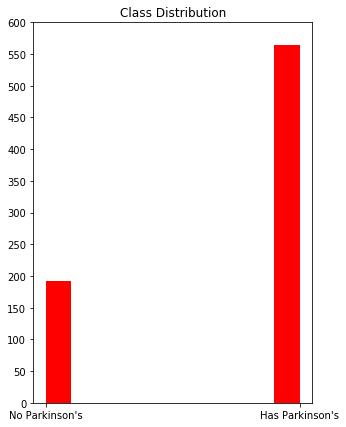

In [2]:
dataset = pd.read_csv("pd_speech_features.csv")
dataset.head()
plt.figure(figsize=(5,7))
plt.hist(dataset["class"], color="red")
plt.title('Class Distribution')
plt.xticks([0,1],["No Parkinson's","Has Parkinson's"])
plt.yticks(np.arange(0, 601, 50))
plt.show()

The classes are pretty unbalanced, so we're probably better off using a balanced accuracy metric to validate the performance of our model. 

# Cleaning up the data

Lets pull the predictors out of the dataset. The "class" column represents each patient's Parkinson's diagnosis; this is the value we're trying to predict. The "id" column represents each patient. This information won't be necessary. 

In [3]:
x_vals = dataset.drop(["class", "id"], axis=1)
labels = dataset["class"]

Alright, now lets see the dimensionality of our predictors. 

In [4]:
print(x_vals.shape)

(756, 753)


For this dataset, there's about as many predictors as observations. This can lead to a big problem in our model: overfitting. We should probably employ some sort of dimensionality reduction to this dataset in order to minimize this chance of overfitting our data. Afterall we want our model to be as generalizable as possible. 

# Principal Component Analysis

Lets try PCA to reduce the amount of predictors down to a reasonable size. By using PCA to fit the model with a handful of predictors, we are less likely to overfit the data.

In [5]:
from sklearn.decomposition import PCA

Let's first try to squash our predictors into two principal components. This way we can visualize the data in two dimensions. 

In [6]:
pca = PCA(n_components=2)

We should start by standardizing all of the predictors, so that all predictors have an equal chance at explaining the relationship in the data. We don't want predictors that use larger units of measurement dominating the principal component selection. Standardizing the predictors allows PCA to look at all predictors equally, so that predictors with larger units of measurement are not  given priority over smaller ones. 

In [7]:
for i in range(x_vals.shape[1]):
    SD = x_vals.iloc[:,i].std()
    x_vals.iloc[:,i] = x_vals.iloc[:,i] / SD

from math import isclose
for i in range(x_vals.shape[1]):
    if (not isclose(1, np.var(x_vals.iloc[:,i]), rel_tol=0.5)):
        print("Not normalized")

Now that the predictors are standardized, lets run PCA on the dataset and graph the result of selecting the top two principal components. 

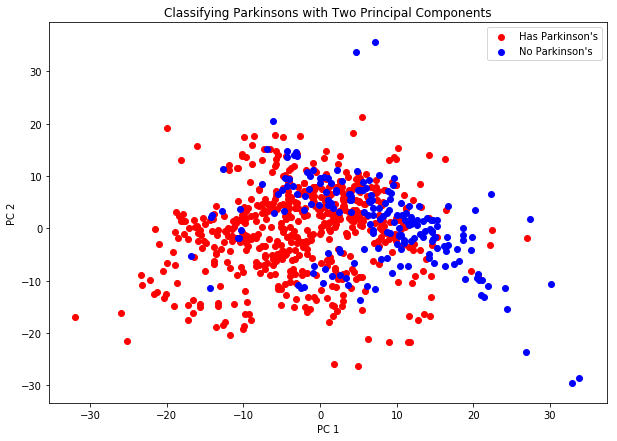

In [8]:
PCs = pca.fit_transform(x_vals)
has_parkinsons = []
no_parkinsons = []
for i in range(len(PCs)):
    if labels[i] == 0:
        no_parkinsons.append([PCs[i][0], PCs[i][1]])
    else: has_parkinsons.append([PCs[i][0], PCs[i][1]])
plt.figure(figsize=(10,7))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Classifying Parkinsons with Two Principal Components")
yes = plt.scatter(np.transpose(has_parkinsons)[0], np.transpose(has_parkinsons)[1], color = "red")
no = plt.scatter(np.transpose(no_parkinsons)[0], np.transpose(no_parkinsons)[1], color = "blue")
plt.legend((yes, no), ("Has Parkinson's", "No Parkinson's"))
plt.show()

The graph above gives us an idea of how well two PCs work at linearly separating the data. As we can see, it doesn't do a fantastic job. There is a lot of overlap shown in the predictors, leading us to two possible methods to try out:

1. We can choose to use more principal components, in hopes that a more reasonable relationship is found.

2. We can choose to use a nonlinear classification method. 

# How many Principal Components?

Let's use a scree plot to determine how many principal components we can get away with using. A scree plot shows the total amount of variance explained by each additional principal component added to the model. 

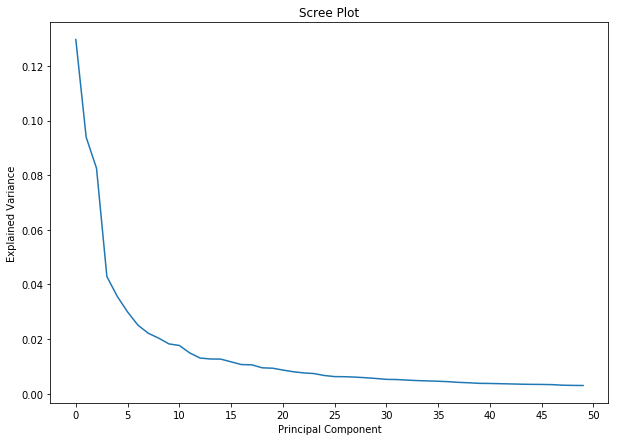

In [9]:
pca = PCA(n_components = 50).fit(x_vals)
plt.figure(figsize=(10,7))
plt.xticks(range(0,55, 5))
plt.title("Scree Plot")
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.plot(pca.explained_variance_ratio_)
plt.savefig("scree.png")
plt.show()

The model starts to slowly converge after the ~10 PC mark, so it's safe to say that we can get away with using 10 PCs. 

# SVM for Nonlinear Classification

As explained above, we're probably going to need a nonlinear classifier to model our Parkinson's predictor on. Let's try an SVM for this. The SVM classifier will utilize the kernel trick in order to create it's own decision boundary for the data. 

Below, we are importing the architecture needed for the support vector classifier. We also need to import sklearn's KFold and train_test_split modules in order to select the best parameters for our model. Finally, the confusion matrix will help us determine the training and testing error of our model. 

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold

Since our data most-likely forms a nonlinear relationship, we'll be using the polynomial kernel function. This adds another question to the list: How do we know which order of polynomial to use in order to get the best testing error? 

# Cross Validation

In order to get an idea for which order performs the strongest in our polynomial kernel, we can:
1. Run the model multiple times, using a different order of polynomial each time
2. Cross-validate each model, in order to get a confident idea of which order of polynomial performs the best. 

In [49]:
pca = PCA(n_components=10)
PCs = pca.fit_transform(x_vals)
mean_scores = []
for i in range(16):
    svcclassifier = SVC(kernel='poly', degree=i, gamma='scale')
    kf = KFold(n_splits = 10, shuffle=True)
    scores = []
    print(i)
    for train_index, test_index in kf.split(PCs):
        X_train, X_validation = PCs[train_index], PCs[test_index]
        y_train, y_validation = labels[train_index], labels[test_index]
        svcclassifier.fit(X_train, y_train)
        y_pred = svcclassifier.predict(X_validation)
        scores.append(bas(y_pred, y_validation))
    mean_scores.append(np.mean(scores))

0
1
2


c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1859: Use

3
4
5
6
7
8
9
10
11
12
13
14
15


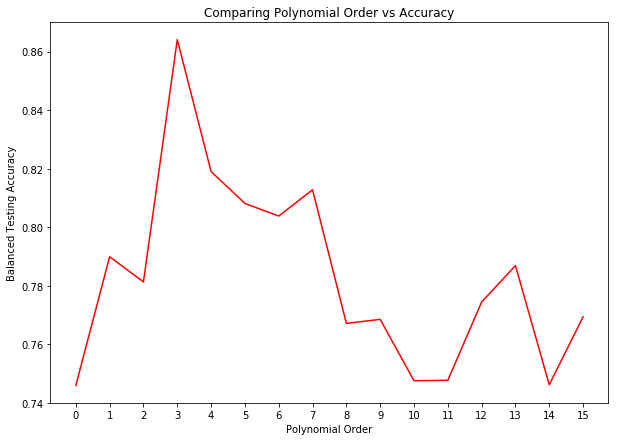

In [51]:
plt.figure(figsize=(10,7))
plt.plot(range(16), mean_scores, color="red")
plt.xticks(range(16))
plt.xlabel("Polynomial Order")
plt.ylabel("Balanced Testing Accuracy")
plt.title("Comparing Polynomial Order vs Accuracy")
plt.savefig("polyorder.png")
plt.show()

The above graph shows the balanced accuracy from fitting the data to multiple different SVM models, with a polynomial ranging from 0 to 15. The results above show that a polynomial order of 3 results in the highest balanced accuracy, so we'll stick with this parameter for our kernel trick. 

# Putting it all together

Above we showed that 10 principal components work well to explain *most* of the variance in the original data. We also showed that using an SVM with a polynomial kernal of order 3 results in the highest balanced accuracy of all the orders from 0 to 15. Now we can put these facts together to create our final model. 

In [33]:
from sklearn.metrics import balanced_accuracy_score as bas

In [55]:
scores = []
pca = PCA(n_components = 10)
PCs = pca.fit_transform(x_vals)
svcclassifier = SVC(kernel = 'poly', degree = 3, gamma = 'scale')
kf = KFold(n_splits = 10, shuffle = True)
for train_index, test_index in kf.split(PCs):
    X_train, X_valid = PCs[train_index], PCs[test_index]
    y_train, y_valid = labels[train_index], labels[test_index]
    svcclassifier.fit(X_train, y_train)
    y_pred = svcclassifier.predict(X_valid)
    scores.append(bas(y_pred, y_valid))
print(np.mean(scores))

0.8436493036398728


With the above hyperparameters, we were able to achieve an average balanced accuracy score of around 85%. 